In [2]:
import os
import numpy as np
import pandas as pd

import pywt

from skimage import util
from scipy import signal

import soundfile as sf

import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import Audio
import sounddevice as sd

%matplotlib inline

In [3]:
os.listdir('duma/flac/Плач невільників')

['Opanas_Slastion_-_Plach_Nevolnykiv_2.flac',
 'Opanas_Slastion_-_Plach_Nevolnykiv_3.flac']

In [4]:
file = 'duma/flac/Плач невільників/Opanas_Slastion_-_Plach_Nevolnykiv_3.flac'
Audio(file)

In [6]:
with open(file, 'rb') as f:
    data, samplerate = sf.read(f)
print(data.shape, samplerate) # mono channel

(4202642,) 44100


Длительность: 18.14 сек


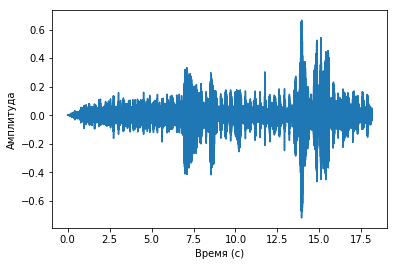

In [7]:
# len(data[:1000000])/samplerate

# 20 секунд
n_times = 800000
N = data[:n_times].shape[0]
L = N / samplerate

print(f'Тривалість: {L:.2f} сек')

f, ax = plt.subplots()
ax.plot(np.arange(N) / samplerate, data[:n_times])
ax.set_xlabel('Час') 
ax.set_ylabel('Амплітуда');

Длительность: 95.30 сек


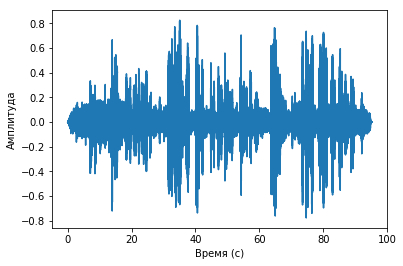

In [8]:
N = data.shape[0]
L = N / samplerate

print(f'Тривалість: {L:.2f} сек')

f, ax = plt.subplots()
ax.plot(np.arange(N) / samplerate, data)
ax.set_xlabel('Час (с)')
ax.set_ylabel('Амплітуда');

In [32]:
util.view_as_windows??

In [9]:
M = 1024

# Rolling window view of the input n-dimensional array.
slices = util.view_as_windows(data, window_shape=(M,), step=100) 
print(f'Розмір аудіофайла: {data.shape}, стало: {slices.shape}')

# Hanning window
win = np.hanning(M + 1)[:-1]
slices = slices * win
slices = slices.T
print('Shape of `slices`:', slices.shape)

spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1] # Fast DFT
spectrum = np.abs(spectrum)

Длина аудиофайла: (4202642,), стало: (42017, 1024)
Shape of `slices`: (1024, 42017)


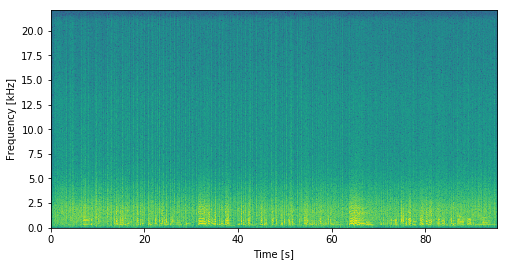

In [10]:
f, ax = plt.subplots(figsize=(8, 4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, samplerate / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

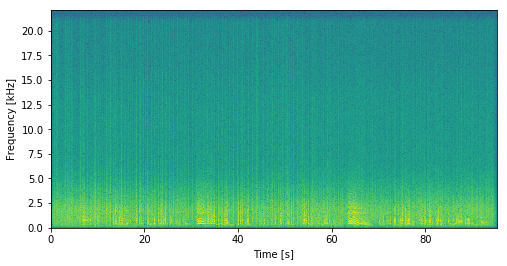

In [58]:
#  то же самое через scipy

freqs, times, Sx = signal.spectrogram(data, fs=samplerate, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(8, 4))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

In [45]:
data.shape # mono channel audio

(4202642,)

In [66]:
# cA, cD = pywt.dwt(data, w)

In [94]:
# f, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(cA)
# axarr[1].plot(cD, c="red")

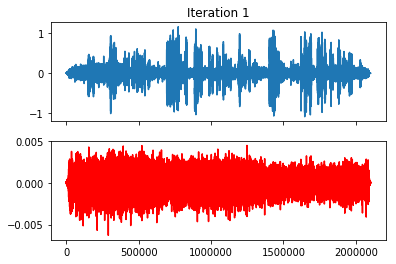

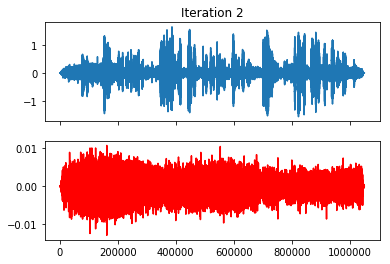

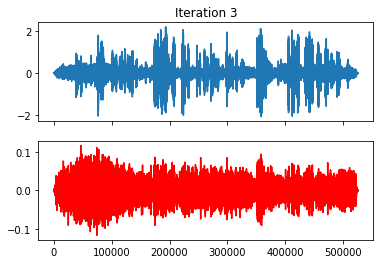

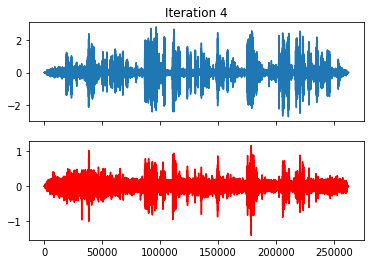

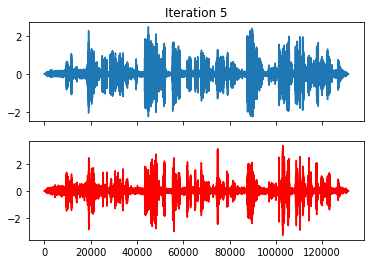

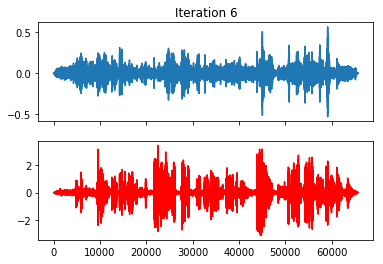

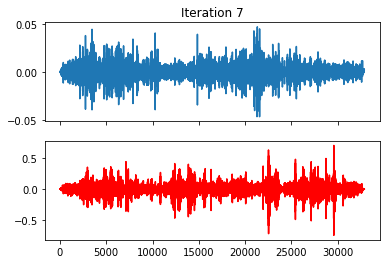

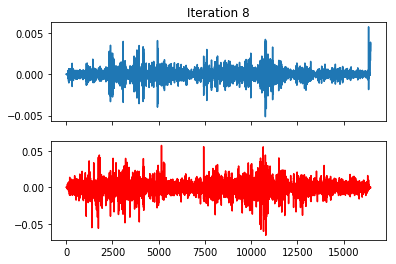

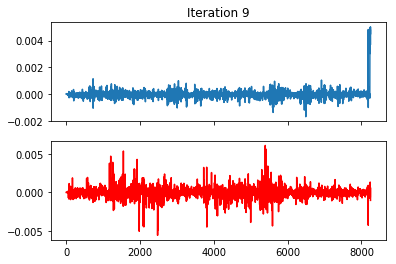

In [170]:
w = pywt.Wavelet('sym20')
# print(w)

coef_mas = []
rate = 0
curr = data
for index in range(1,10):
    cA, cD = pywt.dwt(curr, w) # Approximation and detail coefficients.
    new_rate = rate+2
    coef_mas.append([cA,cD, new_rate]) # new rate = that's not right (((
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(cA)
    axarr[0].set_title('Iteration ' + str(index))
    axarr[1].plot(cD, c="red")
    curr = cA
    rate = new_rate

In [172]:
cA5, cD5, r = coef_mas[-4]

In [173]:
reconstruct = pywt.idwt(cA5, cD5, w)

Длительность: 95.30 сек


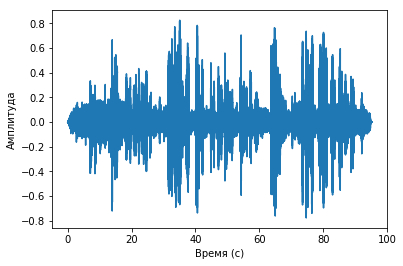

In [164]:
# len(data[:1000000])/samplerate

# первые 20 секунд
# n_times = 800000
N = data.shape[0]
L = N / samplerate

print(f'Тривалість: {L:.2f} сек')

f, ax = plt.subplots()
ax.plot(np.arange(N) / samplerate, data)
ax.set_xlabel('Час (с)')
ax.set_ylabel('Амплітуда');

In [174]:
reconstruct.shape

(131370,)

Длительность: 95.33 сек


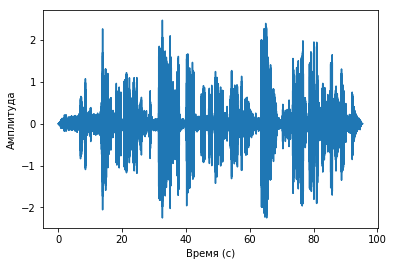

In [184]:
# len(data[:1000000])/samplerate

# первые 20 секунд
# n_times = 800000
N = reconstruct.shape[0]
L = N/ samplerate*32

print(f'Тривалість: {L:.2f} сек')

f, ax = plt.subplots()
ax.plot(np.arange(N) / samplerate*32, reconstruct)
ax.set_xlabel('Час (с)')
ax.set_ylabel('Амплітуда');

In [185]:
sd.play(reconstruct,int(samplerate/32))

In [147]:
iter_ = 2
sd.play(coef_mas[iter_][0], samplerate/(coef_mas[iter_][2] + 2))

In [186]:
sd.stop()

In [183]:
len(reconstruct), len(reconstruct)/int(samplerate/31)

(131370, 92.38396624472574)

In [130]:
len(data), len(data) / samplerate

(4202642, 95.2980045351474)

In [149]:
from scipy.io.wavfile import write


In [169]:
int(samplerate/8)

5512

In [156]:
scaled = np.int16(reconstruct/np.max(np.abs(reconstruct)) * 32767)

In [160]:
write('test.wav', samplerate, scaled)